In [1]:
!pip install urlextract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install emojis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install parsivar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from urlextract import URLExtract
import emojis
from parsivar import FindStems


In [5]:
!pip install nltk
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df_train = pd.read_csv('/content/drive/MyDrive/emotion detection/data/basic/armanTrain.tsv', sep='\t')
df_test = pd.read_csv('/content/drive/MyDrive/emotion detection/data/basic/armanTest.tsv', sep='\t')


In [8]:
df_trian = df_train.drop_duplicates()
df_test = df_test.drop_duplicates()

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6125 entries, 0 to 6124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6125 non-null   object
 1   label   6125 non-null   object
dtypes: object(2)
memory usage: 95.8+ KB


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1151 entries, 0 to 1150
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1151 non-null   object
 1   label   1151 non-null   object
dtypes: object(2)
memory usage: 27.0+ KB


In [11]:
df_train.head()

,text,label
0,خیلی کوچیک هستن و سایزشون بدرد نمیخوره میخوام ...,SAD
1,از صدای پرنده دم دمای صبح متنفرم متنفرم متنفرم,HATE
2,"""کیفیتش خیلی خوبه با شک خریدم ولی واقعا راضیم...",SAD
3,چون همش با دوربین ثبت شده ، ایا میشه اعتراض زد...,OTHER
4,اين وضع ب طرز خنده داري گريه داره ...,SAD


In [12]:
df_train.tail()

,text,label
6120,مرحوم پیش بینی آبکی زیاد میکرد مرحوم عجب آ...,SURPRISE
6121,کلا عین اعتقادات و توئیت زدناتون ... !! در ق...,ANGRY
6122,خب وقتی میگی کسی بیاد مارو بگیره یارو ترس میکن...,FEAR
6123,همون هارو مگه آهنگ جدیدای خواننده‌های دهه ...,SURPRISE
6124,نیم دگیرش چطور حل نیشد,OTHER


In [13]:
df_test.head()

,text,label
0,اين شايد اولين عزاى عمومى واقعى است كه ياد دار...,SAD
1,دیشب بعد از ارسال تویت مربوط به آثار باستانی ت...,HAPPY
2,کدوم شعبه پول نداده، بگو الان برات آمار دقیق ...,OTHER
3,امروز وسط یه بحث با بابا مامانم گفتم آدم باید ...,HAPPY
4,امشب گفت نامزدی دوستش که ادم روشنفکری است بهم ...,SAD


In [14]:
df_test.tail()

,text,label
1146,یعنی این آهنگ مرغ سحر جوری ساخته شده و روی این...,HAPPY
1147,درود بر همه ایرانیان شریف که در این سرما در تظ...,HAPPY
1148,امروز تولدم است،عید است ولی شاد نیستم،عید و تو...,SAD
1149,لعنت به اونی که دلتنگ نگهت میداره...,SAD
1150,من در شگفت انگیز و قبل از بالا رفتن قیمت ها به...,HAPPY


In [15]:
df_test['label'].value_counts()


HAPPY       275
SAD         262
OTHER       193
ANGRY       154
SURPRISE    145
HATE         65
FEAR         57
Name: label, dtype: int64

In [16]:
df_train['label'].value_counts()

OTHER       1681
ANGRY        923
SAD          896
FEAR         757
SURPRISE     739
HAPPY        618
HATE         511
Name: label, dtype: int64

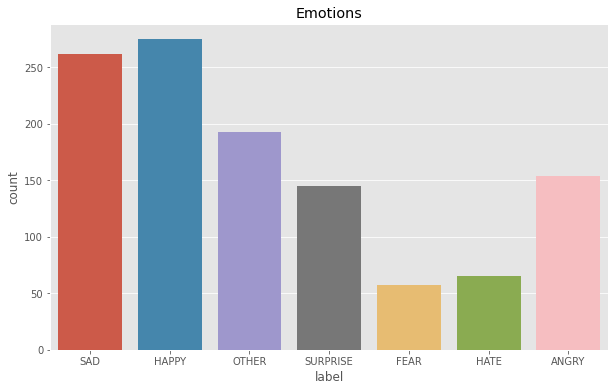

In [17]:
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
sns.countplot(x='label', data=df_test).set(title='Emotions');

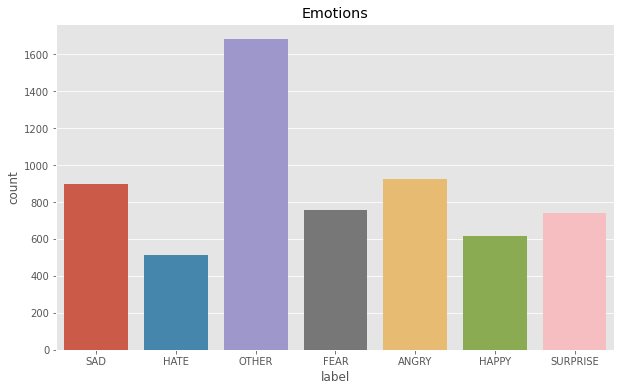

In [18]:
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
sns.countplot(x='label', data=df_train).set(title='Emotions');

In [19]:
def _multiple_replace(mapping, text):
    pattern = "|".join(map(re.escape, mapping.keys()))
    return re.sub(pattern, lambda m: mapping[m.group()], str(text))

def convert_fa_numbers(input_str):
    mapping = {
        '۰': '0',
        '۱': '1',
        '۲': '2',
        '۳': '3',
        '۴': '4',
        '۵': '5',
        '۶': '6',
        '۷': '7',
        '۸': '8',
        '۹': '9',
        '.': '.',
        '۰': '0',
        '١': '1',
        '٢': '2',
        '٣': '3',
        '٤': '4',
        '٥': '5',
        '٦': '6',
        '٧': '7',
        '٨': '8',
        '٩': '9',
    }
    return _multiple_replace(mapping, input_str)


def convert_ar_characters(input_str):
    """
    Converts Arabic chars to related Persian unicode char
    :param input_str: String contains Arabic chars
    :return: New str with converted arabic chars
    """
    mapping = {
        'ك': 'ک',
        'ى': 'ی',
        'ي': 'ی',
        'ئ':'ی',
        'إ':'ا',
        'أ':'ا',
        'ة':'ه',
        'ؤ':'و'
    }
    return _multiple_replace(mapping, input_str)


def preprocess(text):
    extractor = URLExtract()
    for url in extractor.gen_urls(text):
        text = text.replace(url,' ')
    emj = emojis.get(text)
    for i in emj:
        if i in text:
            text = text.replace(i,' ')
    text = convert_fa_numbers(text)
    text = convert_ar_characters(text)
    # regex to detect and replace all smilies in the text with <smiley>
    text = re.sub(r"(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:\s?D|8-\)|:\s?\||;\s?\)|:-\*|:-\||:-\(|:\s?P|:-P|:-p|:-b|:-O|:-o|:-0|:-\@|:\$|:-\^|:-&|:-\*|:-\+|:-\~|:-\`|:-\>|:-\<|:-\}|:-\{|\[:\s?\]|\[:\s?\]|:\s?\]|:\s?\[|:\s?\}|:\s?\{)",'',text)
    text = text.lower() # we lowercase here to prevent changes in the URLs and smilies
    text = text.strip()
    text = re.sub(r'[♥❤٪“”‘’$-;،●•«»|…<>=#.:()"\'!?؟،,@$%^&*_+\[\]/]', ' ', text) 
    # text = re.sub(r'[<>«»#.:()|"\'!?؟،-,@$%؛^&●•={}^$÷…*_+\[\]/]', ' ', text)
    text = re.sub(r'[\s]{2,}', ' ', text)
    text = re.sub(r'(\w)\1{2,}', r'\1',text)
    text = re.sub(r'[A-Za-z]+', '' , text) # remove english words
    text=''.join([i for i in text if not i.isdigit()]) # remove numbers
    if re.search(r'[\u0600-\u06FF]', text):
        return(text)
    else:
        return 'None'


In [20]:
def stemming(text):
  my_stemmer = FindStems()

  text = text.split()

  
  text=[my_stemmer.convert_to_stem (y) for y in text]
  
  return " " .join(text)


In [21]:
def remove_Stopword(text):
    file = nltk.word_tokenize(text)
    newFile=''
    stopWord=[]
    fin=open('/content/drive/MyDrive/emotion detection/data/stopword.txt',encoding='utf8')

    for word in fin.readlines():
        stopWord.append(word.replace('\n', '').lower().replace('\ufeff', '').lower().replace('\ufeff', '').upper().replace(" " ,""))

    for word in file:
        word=word.replace(' ', '')
        if word in stopWord:
            continue
        else:
            newFile = newFile + ' ' + word


    return newFile

In [22]:
# df_train['Cleaned'] = df_train['text'].progress_apply(preprocess)
df_train['cleaned'] = df_train['text'].apply(lambda t: preprocess(t))
df_train['cleaned']


0       خیلی کوچیک هستن و سایزشون بدرد نمیخوره میخوام ...
1          از صدای پرنده دم دمای صبح متنفرم متنفرم متنفرم
2        کیفیتش خیلی خوبه با شک خریدم ولی واقعا راضیم ...
3       چون همش با دوربین ثبت شده ایا میشه اعتراض زد و...
4                      این وضع ب طرز خنده داری گریه داره 
                              ...                        
6120    مرحوم پیش بینی آبکی زیاد میکرد مرحوم عجب آینده...
6121    کلا عین اعتقادات و توییت زدناتون در قبال رانت ...
6122    خب وقتی میگی کسی بیاد مارو بگیره یارو ترس میکن...
6123    همون هارو مگه آهنگ جدیدای خواننده‌های دهه پنجا...
6124                               نیم دگیرش چطور حل نیشد
Name: cleaned, Length: 6125, dtype: object

In [23]:
df_test['cleaned'] = df_test['text'].apply(lambda t: preprocess(t))
df_test['cleaned']

0       این شاید اولین عزای عمومی واقعی است که یاد دار...
1       دیشب بعد از ارسال تویت مربوط به آثار باستانی ت...
2       کدوم شعبه پول نداده بگو الان برات آمار دقیق بد...
3       امروز وسط یه بحث با بابا مامانم گفتم آدم باید ...
4       امشب گفت نامزدی دوستش که ادم روشنفکری است بهم ...
                              ...                        
1146    یعنی این آهنگ مرغ سحر جوری ساخته شده و روی این...
1147    درود بر همه ایرانیان شریف که در این سرما در تظ...
1148    امروز تولدم است عید است ولی شاد نیستم عید و تو...
1149                   لعنت به اونی که دلتنگ نگهت میداره 
1150    من در شگفت انگیز و قبل از بالا رفتن قیمت ها به...
Name: cleaned, Length: 1151, dtype: object

In [24]:
df_train


,text,label,cleaned
0,خیلی کوچیک هستن و سایزشون بدرد نمیخوره میخوام ...,SAD,خیلی کوچیک هستن و سایزشون بدرد نمیخوره میخوام ...
1,از صدای پرنده دم دمای صبح متنفرم متنفرم متنفرم,HATE,از صدای پرنده دم دمای صبح متنفرم متنفرم متنفرم
2,"""کیفیتش خیلی خوبه با شک خریدم ولی واقعا راضیم...",SAD,کیفیتش خیلی خوبه با شک خریدم ولی واقعا راضیم ...
3,چون همش با دوربین ثبت شده ، ایا میشه اعتراض زد...,OTHER,چون همش با دوربین ثبت شده ایا میشه اعتراض زد و...
4,اين وضع ب طرز خنده داري گريه داره ...,SAD,این وضع ب طرز خنده داری گریه داره
...,...,...,...
6120,مرحوم پیش بینی آبکی زیاد میکرد مرحوم عجب آ...,SURPRISE,مرحوم پیش بینی آبکی زیاد میکرد مرحوم عجب آینده...
6121,کلا عین اعتقادات و توئیت زدناتون ... !! در ق...,ANGRY,کلا عین اعتقادات و توییت زدناتون در قبال رانت ...
6122,خب وقتی میگی کسی بیاد مارو بگیره یارو ترس میکن...,FEAR,خب وقتی میگی کسی بیاد مارو بگیره یارو ترس میکن...
6123,همون هارو مگه آهنگ جدیدای خواننده‌های دهه ...,SURPRISE,همون هارو مگه آهنگ جدیدای خواننده‌های دهه پنجا...


In [25]:
df_train['cleaned'] = df_train['cleaned'].apply(lambda t: remove_Stopword(t))
df_train['cleaned']


0              کوچیک هستن سایزشون بدرد نمیخوره میخوام بدم
1                صدای پرنده دمای صبح متنفرم متنفرم متنفرم
2        کیفیتش خوبه شک خریدم واقعا راضیم حدود ماه متا...
3        همش دوربین ثبت ایا اعتراض زد اصن تاثیر اطلاعی...
4                                           طرز خنده گریه
                              ...                        
6120     مرحوم بینی آبکی زیاد میکرد مرحوم عجب آینده نگ...
6121     کلا عین اعتقادات توییت زدناتون قبال رانت نون ...
6122     میگی بیاد مارو بگیره یارو ترس یکم دوست حاله‌ا...
6123     همون هارو آهنگ جدیدای خواننده‌های دهه پنجاه گ...
6124                                    نیم دگیرش حل نیشد
Name: cleaned, Length: 6125, dtype: object

In [26]:
# df_train['Cleaned'] = df_train['text'].progress_apply(preprocess)
df_test['cleaned'] = df_test['cleaned'].apply(lambda t: remove_Stopword(t))
df_test['cleaned']



0        اولین عزای عمومی یاد وجودم عزادار است؛ پر گری...
1        دیشب ارسال تویت مربوط آثار باستانی تویت نوشتم...
2        کدوم شعبه پول نداده برات آمار دقیق بدم شعار ا...
3        وسط بحث بابا مامانم آدم تلاش کنه شادی قلبش بع...
4        امشب نامزدی دوستش ادم روشنفکری بهم خورده دختر...
                              ...                        
1146     آهنگ مرغ سحر جوری شعر نشسته انگار ازل شعر هیش...
1147     درود ایرانیان شریف سرما تظاهرات بیاد ماندنی ز...
1148     تولدم عید شاد عید تولد شادمانه روزی هموطن عقی...
1149                          لعنت اونی دلتنگ نگهت میداره
1150     شگفت انگیز رفتن قیمت پیشنهاد همسرم خرید نتیجه...
Name: cleaned, Length: 1151, dtype: object

In [27]:
# df_train['Cleaned'] = df_train['text'].progress_apply(preprocess)
df_train['stemmed'] = df_train['cleaned'].apply(lambda t: stemming(t))
df_train['stemmed']



0            کوچیک هستن سایزشون درید&در نمیخوره میخوام بد
1                     صدا پرنده دما صبح متنفر متنفر متنفر
2       کیفیت خوبه شک خرید&خر واقعا راضی حدود ماه متاس...
3       هم دوربین ثبت ایا اعتراض زد اصن تاثیر اطلاع مم...
4                                           طرز خنده گریه
                              ...                        
6120    مرحوم بینی آبکی زیاد کرد&کن مرحوم عجب آینده نگ...
6121    کلا عین اعتقادات توی زدناتون قبال ران نون مفت ...
6122    میگ آمد&آ مارو بگیره یارو ترس یکم دوست حاله‌ای...
6123    همون هارو آهنگ جدید خواننده دهه پنجاه گوش دید&بین
6124                                    نیم دگیرش حل نیشد
Name: stemmed, Length: 6125, dtype: object

In [28]:
for index, word in enumerate(df_train['text']):
  word = re.sub('&',' ',word)
  df_train['stemmed'][index] = word

In [29]:
# df_train['Cleaned'] = df_train['text'].progress_apply(preprocess)
df_test['stemmed'] = df_test['cleaned'].apply(lambda t: stemming(t))
df_test['stemmed']



0       اولین عزا عمومی یاد وجود عزادار است؛ پر گریه پ...
1       دیشب ارسال توی مربوط اثر باستانی توی نوشت&نویس...
2       کدو شعبه پول نداده برات آمار دقیق بد شعار الکی...
3       وسط بحث بابا مامان آدم تلاش کنه شادی قلب بعد خ...
4       امشب نامزدی دوست ادم روشنفکری به خورده دختر بش...
                              ...                        
1146    آهنگ مرغ سحر جور شعر نشسته انگار ازل شعر هیشکی...
1147    درود ایرانی شریف سرما تظاهرات آمد&آ ماندنی زیب...
1148    تولد عید شاد عید تولد شادمانه روزی هموطن عقیده...
1149                           لعنت اونی دلتنگ نگه میداره
1150    شگفت انگیخت&انگیز رفتن قیمت پیشنهاد همسر خرید ...
Name: stemmed, Length: 1151, dtype: object

In [30]:
for index, word in enumerate(df_test['text']):
  word = re.sub('&',' ',word)
  df_test['stemmed'][index] = word

In [31]:
df_trian = df_train.drop_duplicates()
df_test = df_test.drop_duplicates()
df_trian = df_trian.dropna()
df_test = df_test.dropna()
df_trian = df_trian.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [32]:
df_trian.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6088 entries, 0 to 6087
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     6088 non-null   object
 1   label    6088 non-null   object
 2   cleaned  6088 non-null   object
 3   stemmed  6088 non-null   object
dtypes: object(4)
memory usage: 190.4+ KB


In [33]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     1151 non-null   object
 1   label    1151 non-null   object
 2   cleaned  1151 non-null   object
 3   stemmed  1151 non-null   object
dtypes: object(4)
memory usage: 36.1+ KB


In [34]:
df_train.to_csv('/content/drive/MyDrive/emotion detection/data/basic/armanTrainCleaned.csv', index=False)
df_test.to_csv('/content/drive/MyDrive/emotion detection/data/basic/armanTestCleaned.csv', index=False)
